<a href="https://colab.research.google.com/github/akankshakusf/Project-DeepLearning-Human-Emotions-Detection-Model/blob/master/Human_Emotion_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Import packages
import numpy as np
from datetime import datetime
import pathlib
import io
import os
import time
import random
from google.colab import files
import sklearn
import cv2 #computer vision
from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns
import matplotlib.pyplot as plt


#tensorflow packages
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Layer,Activation, MaxPooling2D, Add, Conv2D, MaxPool2D,GlobalAveragePooling2D, Dense,
                                     Flatten, InputLayer, BatchNormalization, Input, Embedding, Permute,
                                     Dropout, RandomFlip, RandomRotation, LayerNormalization, MultiHeadAttention,
                                     RandomContrast, Rescaling, Resizing, Reshape,Lambda)
from tensorflow.keras.losses import BinaryCrossentropy,CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy,TopKCategoricalAccuracy, CategoricalAccuracy, SparseCategoricalAccuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (Callback, CSVLogger, EarlyStopping, LearningRateScheduler,
                                        ModelCheckpoint, ReduceLROnPlateau)
from tensorflow.keras.regularizers  import L2, L1
from tensorflow.train import BytesList, FloatList, Int64List
from tensorflow.train import Example, Features, Feature

# Define main_directory Structure

In [2]:
train_directory="/content/dataset/Emotions Dataset/Emotions Dataset/train"
val_directory = "/content/dataset/Emotions Dataset/Emotions Dataset/test"

# Params Dictionary

In [3]:

CONFIGURATION={
        "BATCH_SIZE":32,
        "IM_SIZE":256,
        "LEARNING_RATE":0.001,
        "N_EPOCHS":20,
        "DROPOUT_RATE":0.0,
        "REGULARIZATION_RATE":0.0,
        "N_FILTERS":6,
        "KERNEL_SIZE":3,
        "N_STRIDES":1,
        "POOL_SIZE":2,
        "N_DENSE_1":1024,
        "N_DENSE_2":128,
        "NUM_CLASSES":3,
        "CLASS_NAMES": ["angry", "happy", "sad"],
        "PATCH_SIZE":16
}

# Data Management

## Data Downloading- Importing Kaggle Dataset

In [4]:
!pip install -q kaggle

In [5]:
import os
import zipfile

# Make a hidden .kaggle folder
os.makedirs("/root/.kaggle", exist_ok=True)

# Move kaggle.json to the folder
!mv kaggle.json /root/.kaggle/

# Set permissions
!chmod 600 /root/.kaggle/kaggle.json

In [6]:
!kaggle datasets download -d muhammadhananasghar/human-emotions-datasethes

Dataset URL: https://www.kaggle.com/datasets/muhammadhananasghar/human-emotions-datasethes
License(s): unknown


In [7]:
!unzip "/content/human-emotions-datasethes.zip" -d "/content/dataset/"

Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/EmotionsDataset/data/nothing/720.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/721.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/722.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/723.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/724.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/725.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/726.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/727.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/728.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/729.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/73.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/730.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/731.jpg  
  inflating: /content/dataset/EmotionsDataset/data/no

## Dataset Loading

In [8]:
train_dataset= tf.keras.preprocessing.image_dataset_from_directory(
    train_directory,
    labels='inferred',
    label_mode='categorical', #one hot endoded
    class_names=CONFIGURATION["CLASS_NAMES"],
    color_mode='rgb',
    batch_size=32,
    image_size=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
    shuffle=True,
    seed=99,
)

Found 6799 files belonging to 3 classes.


In [9]:
val_dataset= tf.keras.preprocessing.image_dataset_from_directory(
    val_directory,
    labels='inferred',
    label_mode='categorical', #one hot endoded
    class_names=CONFIGURATION["CLASS_NAMES"],
    color_mode='rgb',
    batch_size=CONFIGURATION["BATCH_SIZE"],
    image_size=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
    shuffle=True,
    seed=99,
)

Found 2278 files belonging to 3 classes.


In [10]:
for i in val_dataset.take(1):
  print(i)

(<tf.Tensor: shape=(32, 256, 256, 3), dtype=float32, numpy=
array([[[[ 20.        ,  20.        ,  20.        ],
         [ 19.1875    ,  19.1875    ,  19.1875    ],
         [ 19.        ,  19.        ,  19.        ],
         ...,
         [ 29.125     ,  29.125     ,  29.125     ],
         [ 25.        ,  25.        ,  25.        ],
         [ 25.        ,  25.        ,  25.        ]],

        [[ 20.        ,  20.        ,  20.        ],
         [ 19.847656  ,  19.847656  ,  19.847656  ],
         [ 19.8125    ,  19.8125    ,  19.8125    ],
         ...,
         [ 28.820312  ,  28.820312  ,  28.820312  ],
         [ 25.660156  ,  25.660156  ,  25.660156  ],
         [ 25.        ,  25.        ,  25.        ]],

        [[ 20.6875    ,  20.6875    ,  20.6875    ],
         [ 21.246094  ,  21.246094  ,  21.246094  ],
         [ 21.847656  ,  21.847656  ,  21.847656  ],
         ...,
         [ 25.3125    ,  25.3125    ,  25.3125    ],
         [ 22.375     ,  22.375     ,  22.375 

## Dataset Visualization

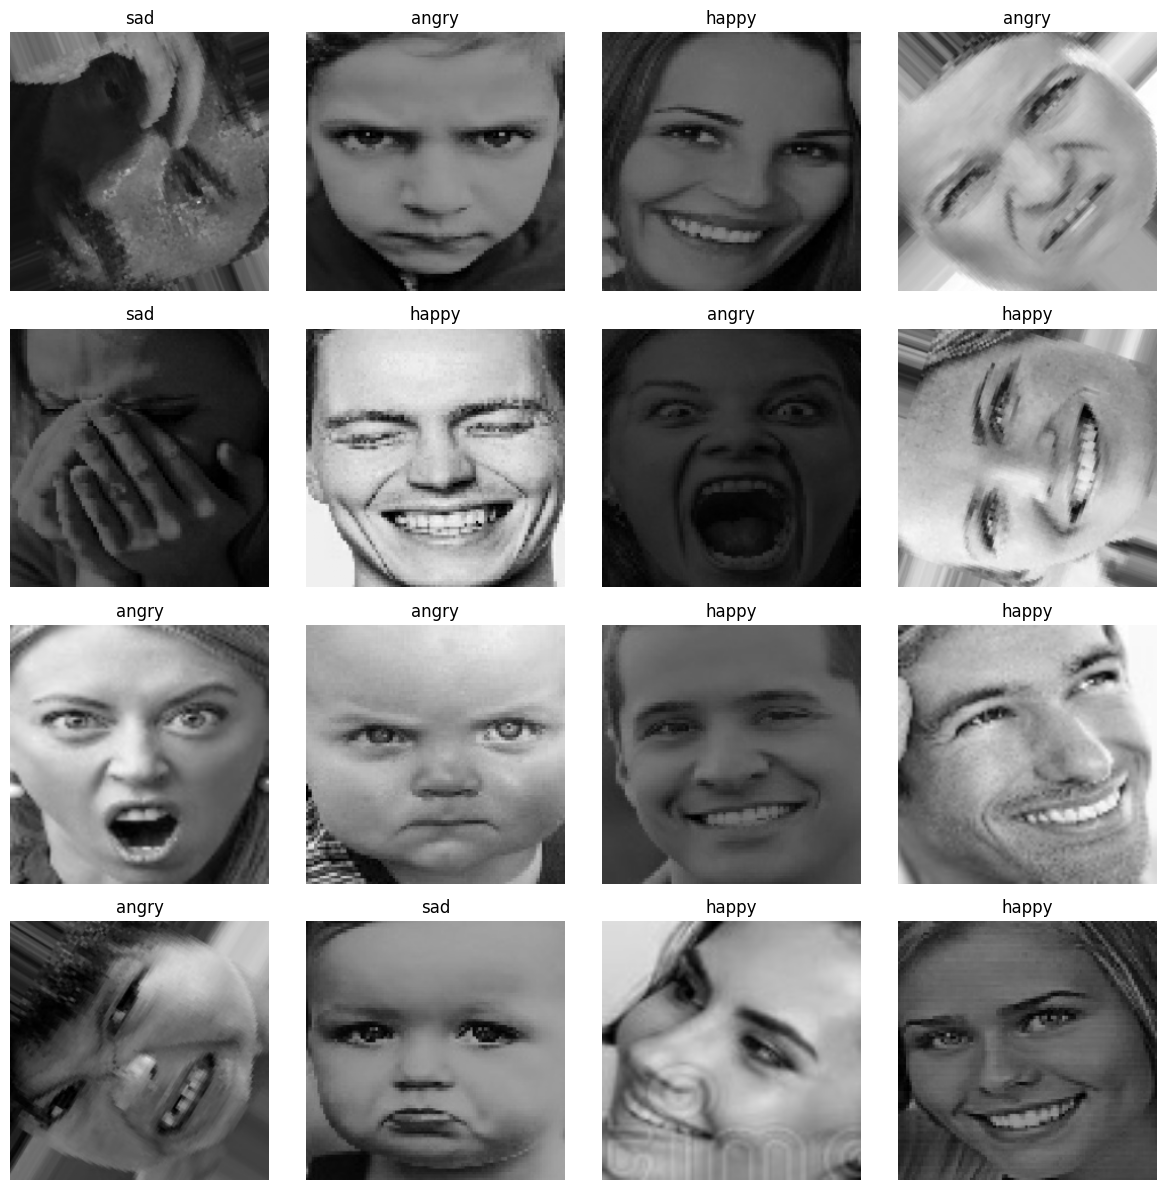

In [11]:
# Get one batch
images, labels = next(iter(train_dataset))
plt.figure(figsize=(12, 12))

for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(images[i].numpy() / 255.0)  # normalize and convert tensor to numpy
    plt.title(CONFIGURATION["CLASS_NAMES"][tf.argmax(labels[i], axis=0).numpy()])  # convert one-hot to class index
    plt.axis('off')

plt.tight_layout()
plt.show()

## Data Augmentation

- reference: https://www.tensorflow.org/api_docs/python/tf/keras/layers

In [12]:
# 1.Augmented layer with "layers method" rotation/flip/contrast
augment_layers = tf.keras.Sequential([
       RandomRotation(factor = (0.25, 0.2501),),
       RandomFlip(mode='horizontal',),
       RandomContrast(factor=0.1),
])

In [13]:
def augment_layer(image,label):
  return augment_layers(image, training=True), label

In [14]:
## 2.Augmented layer with "layers method" for resizing and rescaling
resize_rescale_layers = tf.keras.Sequential([
    Resizing(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
    Rescaling(1.0 / 255),
])

## CutMix Data Augmentation

In [15]:
def box(lamda):

  # Randomly select a center point (x, y) for the patch within the image
  r_x = tf.cast(tfp.distributions.Uniform(0, CONFIGURATION['IM_SIZE']).sample(1)[0], dtype=tf.int32)
  r_y = tf.cast(tfp.distributions.Uniform(0, CONFIGURATION['IM_SIZE']).sample(1)[0], dtype=tf.int32)

  # Calculate the width and height of the patch based on how much of the image we want to replace
  r_w = tf.cast(CONFIGURATION['IM_SIZE'] * tf.math.sqrt(1 - lamda), dtype=tf.int32)
  r_h = tf.cast(CONFIGURATION['IM_SIZE'] * tf.math.sqrt(1 - lamda), dtype=tf.int32)

  # Adjust the top-left corner so the patch stays within image boundaries
  r_x = tf.clip_by_value(r_x - r_w // 2, 0, CONFIGURATION['IM_SIZE'])
  r_y = tf.clip_by_value(r_y - r_h // 2, 0, CONFIGURATION['IM_SIZE'])

  #find the x,y bottom right
  x_b_r= tf.clip_by_value(r_x + r_w // 2, 0, CONFIGURATION['IM_SIZE'])
  y_b_r = tf.clip_by_value(r_y + r_h // 2, 0, CONFIGURATION['IM_SIZE'])

  #final value of r_w,r_h
  r_w = x_b_r - r_x
  if (r_w == 0):
    r_w = 1

  r_h = y_b_r - r_y
  if (r_h == 0):
    r_h = 1

  # Print the top-left corner (r_x, r_y) and size (r_w, r_h) of the patch to be cut and mixed
  return r_y, r_x, r_h, r_w

In [16]:
# Create a method to perform MixUp by combining two training images

def cutmix(train_dataset_1, train_dataset_2):
  # Draw a random value from a Beta distribution to decide how much to mix two images
  lamda = tfp.distributions.Beta(0.2, 0.2)  ### 0.2 is a standard
  lamda = lamda.sample(1)[0]

  r_y,r_x, r_h, r_w = box(lamda)

  # Unpack images and labels from both datasets
  (image_1, label_1), (image_2, label_2) = train_dataset_1, train_dataset_2

  # Cut a rectangular patch from image_2
  crop_2 = tf.image.crop_to_bounding_box(image_2, r_y, r_x, r_h, r_w)
  # Place the cropped patch onto a blank canvas (same size as image) at a specific location
  pad_2 = tf.image.pad_to_bounding_box(crop_2, r_y, r_x, CONFIGURATION['IM_SIZE'], CONFIGURATION['IM_SIZE'])

  # Do the same crop and pad for image_1 (to subtract the patch area later)
  crop_1 = tf.image.crop_to_bounding_box(image_1, r_y, r_x, r_h, r_w)
  pad_1 = tf.image.pad_to_bounding_box(crop_1,r_y, r_x, CONFIGURATION['IM_SIZE'], CONFIGURATION['IM_SIZE'])

  # Replace the patch in image_1 with the patch from image_2
  image = image_1 - pad_1 + pad_2

  lamda= tf.cast(1-(r_w*r_h)/(CONFIGURATION['IM_SIZE']*CONFIGURATION['IM_SIZE']),dtype=tf.float32)
  label = lamda*tf.cast(label_1,dtype=tf.float32) + (1-lamda)*tf.cast(label_2,dtype=tf.float32)

  # Return the mixed image and the label (currently label_1 only)
  return image, label

## Dataset Preparation

- let tf pre fetch batches in the background while the model is training on the current batch
- let tf automatically choose the optimal number of batches to prefetch based on system performance.

In [17]:
# create a mixed datasets
train_dataset_1= train_dataset.map(augment_layer,num_parallel_calls=tf.data.AUTOTUNE)
train_dataset_2= train_dataset.map(augment_layer,num_parallel_calls=tf.data.AUTOTUNE)

mixed_dataset=tf.data.Dataset.zip(train_dataset_1, train_dataset_2) # comment when using Albumentation

In [ ]:
# #prefetch and autotune
# train_dataset=(train_dataset
#                .map(augment_layer, num_parallel_calls=tf.data.AUTOTUNE)
#                .prefetch(tf.data.AUTOTUNE))

In [18]:
# Training pipeline with augmentation
train_dataset = (
    mixed_dataset
    .map(cutmix,num_parallel_calls=tf.data.AUTOTUNE)
    #.batch(CONFIGURATION['BATCH_SIZE'])
    .prefetch(tf.data.AUTOTUNE)
)

In [19]:
val_dataset=(val_dataset
             .prefetch(tf.data.AUTOTUNE))

In [20]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>

In [21]:
val_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>

# Modelling

## Simple Sequential LeNet Model

In [22]:
# clear up session cache
from tensorflow.keras import backend as K
# Clear the previous session to reset layer count
K.clear_session()

In [23]:
'''
1. Instantiate the CNN model "Simple Sequential Model"
'''

lenet_model = tf.keras.Sequential([

    #InputLayer(shape = (None, None, 3), ),
    InputLayer(input_shape = (CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"],3)),

    resize_rescale_layers, # embedding resize and rescale into SequentialAPI
    augment_layers,

    # 1st conv layer (extracts basic patterns)
    Conv2D(filters=CONFIGURATION["N_FILTERS"], kernel_size=CONFIGURATION["KERNEL_SIZE"],
           strides=CONFIGURATION["N_STRIDES"],
           padding="valid", activation="relu",
           kernel_regularizer=L2(CONFIGURATION["REGULARIZATION_RATE"])),

    BatchNormalization(),
    MaxPool2D(pool_size=CONFIGURATION["POOL_SIZE"],
              strides=CONFIGURATION["N_STRIDES"]*2),  # Downsamples feature maps

    Dropout(rate=CONFIGURATION["DROPOUT_RATE"]),   #add a dropout layer

    # 2nd conv layer (extracts deeper features)
    Conv2D(filters=CONFIGURATION["N_FILTERS"]*2+4, kernel_size=CONFIGURATION["KERNEL_SIZE"],
           strides=CONFIGURATION["N_STRIDES"],
           padding="valid", activation="relu",
           kernel_regularizer=L2(CONFIGURATION["REGULARIZATION_RATE"])),

    BatchNormalization(),
    MaxPool2D(pool_size=CONFIGURATION["POOL_SIZE"], strides=CONFIGURATION["N_STRIDES"]*2),  # Downsampling again


    Flatten(),  # Converts 2D feature maps into 1D array

    Dense(CONFIGURATION["N_DENSE_1"], activation="relu",kernel_regularizer=L2(CONFIGURATION["REGULARIZATION_RATE"])),  # Fully connected layer
    BatchNormalization(),
    Dropout(rate=CONFIGURATION["DROPOUT_RATE"]),   #add a dropout layer

    Dense(CONFIGURATION["N_DENSE_2"], activation="relu",
          kernel_regularizer=L2(CONFIGURATION["REGULARIZATION_RATE"])),   # Further processing
    BatchNormalization(),

    Dense(CONFIGURATION["NUM_CLASSES"], activation="softmax"),     # Output layer (multi-class classification)

])

# Print model summary
lenet_model.summary()



/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)            │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential (Sequential)              │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 254, 254, 6)         │             168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 254, 254, 6)         │              24 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 127, 127, 6)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 127, 127, 6)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 125, 125, 16)        │             880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 125, 125, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 62, 62, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 61504)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │      62,981,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 1024)                │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 63,118,451 (240.78 MB)

 Trainable params: 63,116,103 (240.77 MB)

 Non-trainable params: 2,348 (9.17 KB)

## ResNet Model : Deep Residual Learning for Image Recognition

### CustomConv2D

In [24]:
# Custom layer inherits from layers class
class CustomConv2D(Layer):
  def __init__(self,n_filters,kernel_size,n_strides,padding='valid'): #Constructor: defines the layers used in the model
    super(CustomConv2D,self).__init__(name='custom_conv2d')

    #combining Conv2D + ReLU + BatchNormalization
    self.conv=Conv2D(
        filters=n_filters,
        kernel_size=kernel_size,
        activation='relu',
        strides=n_strides,
        padding=padding
    )

    self.batch_norm= BatchNormalization()

  def call(self,x,training=True):

    x=self.conv(x)
    x=self.batch_norm(x,training=training)

    return x

### Residual Block

In [25]:
# My ResidualBlock custom class inherits from the "Layer" class
class ResidualBlock(Layer):
  def __init__(self,n_channels, n_strides=1):
    super(ResidualBlock,self).__init__(name="res_block")
    self.dotted = (n_strides != 1) # Shortcut projection needed when stride != 1

     # Main path
    self.custom_conv_1 = CustomConv2D(n_channels,3,n_strides,padding="same")
    self.custom_conv_2 = CustomConv2D(n_channels, 3, 1, padding ="same")
    self.activation = Activation("relu")

     # Shortcut path (1x1 conv to match shape if stride != 1)
    if self.dotted:
      self.custom_conv_3 = CustomConv2D(n_channels,1,n_strides)


  def call(self,input,training=True):

    x=self.custom_conv_1(input,training=training)
    x=self.custom_conv_2(x,training=training)

    if self.dotted:
      x_add = self.custom_conv_3(input,training=training)
      x_add = Add()([x,x_add])

    else:
      x_add= Add()([x,input])

    return self.activation(x_add)


### Complete Network

In [26]:
# My ResNet34 custom class inherits from the Model class
class ResNet34(Model):
  def __init__(self,):# Constructor: defines the layers used in the model
    super(ResNet34,self).__init__(name='resnet_34')

    # Initial convolution and max pooling layers
    self.conv_1= CustomConv2D(64,7,2,padding='same')
    self.max_pool=MaxPooling2D(3,2)

    # Residual blocks for each stage of the network
    self.conv_2_1 = ResidualBlock(64)
    self.conv_2_2 = ResidualBlock(64)
    self.conv_2_3 = ResidualBlock(64)

    self.conv_3_1 = ResidualBlock(128,2)
    self.conv_3_2 = ResidualBlock(128)
    self.conv_3_3 = ResidualBlock(128)
    self.conv_3_4 = ResidualBlock(128)

    self.conv_4_1 = ResidualBlock(256,2)
    self.conv_4_2 = ResidualBlock(256)
    self.conv_4_3 = ResidualBlock(256)
    self.conv_4_4 = ResidualBlock(256)
    self.conv_4_5 = ResidualBlock(256)
    self.conv_4_6 = ResidualBlock(256)

    self.conv_5_1 = ResidualBlock(512,2)
    self.conv_5_2 = ResidualBlock(512)
    self.conv_5_3 = ResidualBlock(512)

    # Global average pooling and final dense layer
    self.global_pool = GlobalAveragePooling2D()

    self.fc_3 = Dense(CONFIGURATION["NUM_CLASSES"], activation='softmax')


  def call(self,x,training=True): # Forward pass: defines how input data flows through the model
    x=self.conv_1(x)
    x=self.max_pool(x)

    x=self.conv_2_1(x, training=training)
    x=self.conv_2_2(x, training=training)
    x=self.conv_2_3(x, training=training)

    x=self.conv_3_1(x, training=training)
    x=self.conv_3_2(x, training=training)
    x=self.conv_3_3(x, training=training)
    x=self.conv_3_4(x, training=training)

    x=self.conv_4_1(x, training=training)
    x=self.conv_4_2(x, training=training)
    x=self.conv_4_3(x, training=training)
    x=self.conv_4_4(x, training=training)
    x=self.conv_4_5(x, training=training)
    x=self.conv_4_6(x, training=training)

    x=self.conv_5_1(x, training=training)
    x=self.conv_5_2(x, training=training)
    x=self.conv_5_3(x, training=training)

    x= self.global_pool(x)

    return self.fc_3(x)

In [27]:
resnet_34 = ResNet34()
resnet_34(tf.zeros([1, 256, 256, 3]),training=False)  # Force build with dummy input
resnet_34.summary()

Model: "resnet_34"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ custom_conv2d (CustomConv2D)         │ ?                           │           9,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ res_block (ResidualBlock)            │ ?                           │          74,368 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ res_block (ResidualBlock)            │ ?                           │          74,368 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ res_block (ResidualBlock)            │ ?                           │          74,368 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ res_block (ResidualBlock)            │ ?                           │         231,296 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ res_block (ResidualBlock)            │ ?                           │         296,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ res_block (ResidualBlock)            │ ?                           │         296,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ res_block (ResidualBlock)            │ ?                           │         296,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ res_block (ResidualBlock)            │ ?                           │         921,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ res_block (ResidualBlock)            │ ?                           │       1,182,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ res_block (ResidualBlock)            │ ?                           │       1,182,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ res_block (ResidualBlock)            │ ?                           │       1,182,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ res_block (ResidualBlock)            │ ?                           │       1,182,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ res_block (ResidualBlock)            │ ?                           │       1,182,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ res_block (ResidualBlock)            │ ?                           │       3,677,696 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ res_block (ResidualBlock)            │ ?                           │       4,723,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ res_block (ResidualBlock)            │ ?                           │       4,723,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ ?                           │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (1, 3)                      │           1,539 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,311,747 (81.30 MB)

 Trainable params: 21,294,723 (81.23 MB)

 Non-trainable params: 17,024 (66.50 KB)

## Modelling with Pre trained Models

### Transfer Learning with EfficientNet

* This function returns a Keras image classification model, optionally loaded with weights pre-trained on ImageNet.

In [28]:
#Instantiates the EfficientNetB4 Model
backbone= tf.keras.applications.EfficientNetB4(
    include_top=False,
    weights='imagenet',
    input_shape=(CONFIGURATION["IM_SIZE"],CONFIGURATION["IM_SIZE"],3)
)

71686520/71686520 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [29]:
#disable backbone: for trainable we are not going to update the weight of the pretrained model
backbone.trainable=False

In [30]:
#Instantiating my pretrained model
pretrained_model =tf.keras.Sequential([
    Input(shape=(CONFIGURATION['IM_SIZE'],CONFIGURATION['IM_SIZE'],3)),
    backbone,
    GlobalAveragePooling2D(),
    Dense(CONFIGURATION["N_DENSE_1"], activation='relu'),
    BatchNormalization(),
    Dense(CONFIGURATION["N_DENSE_2"], activation='relu'),
    Dense(CONFIGURATION["NUM_CLASSES"], activation='softmax'),
])
pretrained_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb4 (Functional)          │ (None, 8, 8, 1792)          │      17,673,823 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 1792)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1024)                │       1,836,032 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_40               │ (None, 1024)                │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 128)                 │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,645,538 (74.94 MB)

 Trainable params: 1,969,667 (7.51 MB)

 Non-trainable params: 17,675,871 (67.43 MB)

### FineTuning with EfficientNet

In [32]:
#enable backbone: for trainable we are going to update the weight of the pretrained model
backbone.trainable=True

In [33]:
#Instantiating my fine tuning layers

input = Input(shape=(CONFIGURATION['IM_SIZE'],CONFIGURATION['IM_SIZE'],3))

x = backbone(input, training= False) #setting training to false meaning use the same mean and std found training inputs training
x = GlobalAveragePooling2D()(x)
x = Dense(CONFIGURATION["N_DENSE_1"], activation='relu')(x)
x = BatchNormalization()(x) #this is running in inference mode now
x = Dense(CONFIGURATION["N_DENSE_2"], activation='relu')(x)

output = Dense(CONFIGURATION["NUM_CLASSES"], activation='softmax')(x)

#instantiate the model
finetined_model = Model(input, output)
finetined_model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb4 (Functional)          │ (None, 8, 8, 1792)          │      17,673,823 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 1792)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1024)                │       1,836,032 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_41               │ (None, 1024)                │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 128)                 │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,645,538 (74.94 MB)

 Trainable params: 19,518,283 (74.46 MB)

 Non-trainable params: 127,255 (497.09 KB)

## Vision Transformers

### Patch Encoder

In [34]:
test_image = cv2.imread("/content/dataset/Emotions Dataset/Emotions Dataset/test/sad/105565.jpg_brightness_1.jpg")
test_image = cv2.resize(test_image, (CONFIGURATION['IM_SIZE'],CONFIGURATION['IM_SIZE']))

In [35]:
#check the shape of test.image
print(test_image.shape)  ## we need to make it 4D,
print(tf.expand_dims(test_image, axis =0))
print((tf.expand_dims(test_image, axis =0)).shape)  ## i have added an extra dimension

(256, 256, 3)
tf.Tensor(
[[[[84 84 84]
   [85 85 85]
   [83 83 83]
   ...
   [ 8  8  8]
   [ 8  8  8]
   [ 8  8  8]]

  [[85 85 85]
   [86 86 86]
   [84 84 84]
   ...
   [ 8  8  8]
   [ 8  8  8]
   [ 9  9  9]]

  [[86 86 86]
   [87 87 87]
   [84 84 84]
   ...
   [11 11 11]
   [11 11 11]
   [11 11 11]]

  ...

  [[77 77 77]
   [77 77 77]
   [78 78 78]
   ...
   [ 4  4  4]
   [ 4  4  4]
   [ 3  3  3]]

  [[76 76 76]
   [77 77 77]
   [77 77 77]
   ...
   [ 5  5  5]
   [ 4  4  4]
   [ 3  3  3]]

  [[77 77 77]
   [77 77 77]
   [77 77 77]
   ...
   [ 5  5  5]
   [ 5  5  5]
   [ 4  4  4]]]], shape=(1, 256, 256, 3), dtype=uint8)
(1, 256, 256, 3)


reference= https://www.tensorflow.org/api_docs/python/tf/image/extract_patches

In [ ]:
# ### this is code testing
# sizes=[1,CONFIGURATION['PATCH_SIZE'],CONFIGURATION['PATCH_SIZE'], 1]
# print(sizes)
# strides=[1,CONFIGURATION['PATCH_SIZE'],CONFIGURATION['PATCH_SIZE'], 1]
# print(strides)
## this is fine !! but to this now we need to all 16*16*3 where 3 will be three channels RGB

In [36]:
#patches will have no of dimensions through which this 16*16 image will be send to encoder
patches=tf.image.extract_patches(images=tf.expand_dims(test_image, axis =0),
                           sizes=[1,CONFIGURATION['PATCH_SIZE'],CONFIGURATION['PATCH_SIZE'], 1],
                           strides=[1,CONFIGURATION['PATCH_SIZE'],CONFIGURATION['PATCH_SIZE'], 1],
                           rates=[1, 1, 1, 1],
                           padding='VALID')

In [37]:
#check the patches shape
print(patches.shape)
# 1 image → 16 rows x 16 columns of patches → each patch is a vector of 768 values

(1, 16, 16, 768)


*Note : Looking at this shape (batch, 16, 16, patch_dim) (1, 16, 16, 768)  we can say that,
since we have IM_SIZE = 256, Then for the R,Y,B channels we will have
256X3 = 768.
This is how we have gotten that 4th dimension, that shows no. of dimensions this 16X16 will be represented

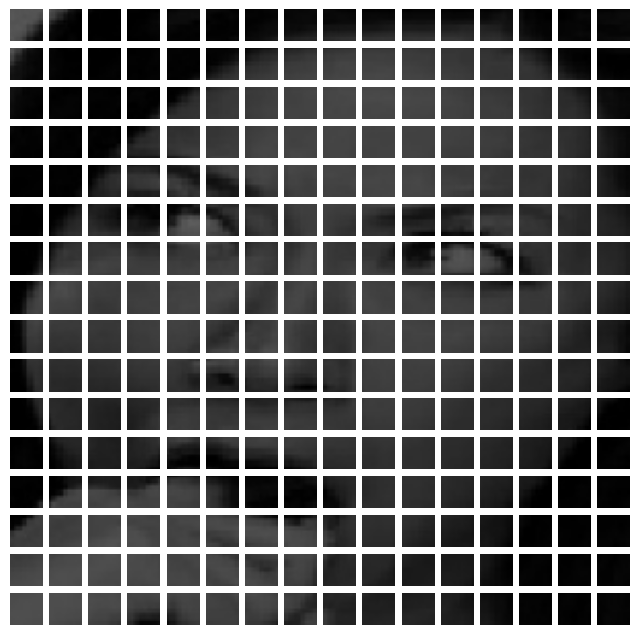

In [38]:
#now to plot this we will go to each and every patch

plt.figure(figsize=(8, 8))

# Initialize a counter to keep track of the patches
k = 0
# Loop over 16 rows of patches
for i in range(16):
    # Loop over 16 columns of patches
    for j in range(16):
        # Create a subplot in a 16x16 grid layout, placing the current patch at position k+1
        ax = plt.subplot(16, 16, k + 1)

        # Take the k-th patch & flatten i.e reshape it back to a 16x16 RGB
        plt.imshow(tf.reshape(patches[0, i, j, :], (16, 16, 3)))
        plt.axis('off')

        # Move to the next patch
        k += 1

plt.show()

In [39]:
#now change the shape of patches back to 256 (just combine 16X16)
patches = tf.reshape(patches, (1, 256, 768))
# same thing like above
##patches = tf.reshape(patches, (patches.shape[0],-1, 768))
print(patches.shape)

(1, 256, 768)


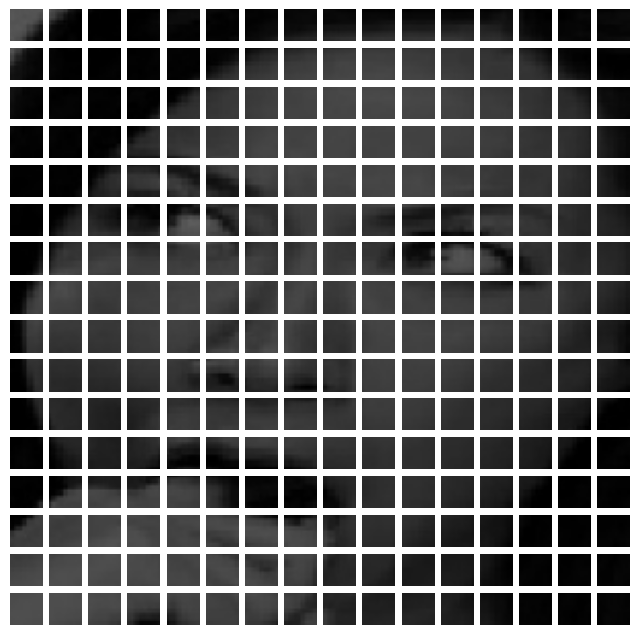

In [40]:
#now plot these patches similar to above but like this (batch, 256, patch_dim)
plt.figure(figsize=(8,8))

k=0
for i in range(patches.shape[1]):
  ax = plt.subplot(16,16,i+1)
  # break down 768 = 16*16*3 → patch size of 16x16 pixels with 3 color channels (RGB)
  plt.imshow(tf.reshape(patches[0,i,:],(16,16,3)))
  plt.axis('off')
  k+=1

plt.show()


*I am doing this
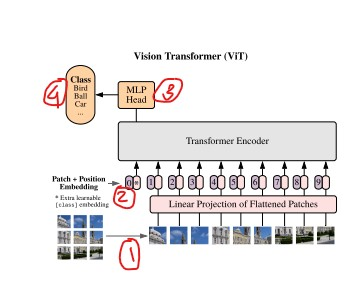

In [ ]:
#### Explaination of of how to generate :
# we want to make(B,Np,Hd) = (1,256,768)
# B = batches, Np: no of patches, Hd: hidden dimensions

# model = tf.keras.Sequential()
# model.add(tf.keras.layers.Embedding(256,768))
# input_array = np.random.randint(1000, size=(1, 256))
# model.compile('rmsprop', 'mse')
# output_array = model.predict(input_array)
# print(output_array.shape)

* Embedding reference: https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding
* PatchEncoder splits the image into small patches and projects each patch into a fixed-sized vector (like an embedding).

In [41]:
# My PatchEncoder custom class inherits from the Model class
class PatchEncoder(Layer):
  def __init__(self,N_PATCHES, HIDDEN_SIZE): #Constructor: defines the layers used in the model
    super(PatchEncoder,self).__init__(name='patch_encoder')

    ## refer diagram to understand better
    self.linear_projection=Dense(HIDDEN_SIZE)  #linear Projection
    self.positional_embedding=Embedding(N_PATCHES,HIDDEN_SIZE) #positional embedding
    self.N_PATCHES=N_PATCHES    # flatten patches

  def call(self,x): ## Forward pass: defines how input data flows through the model

    #step 1: Extracts patches from an input image. how done above
    patches=tf.image.extract_patches(
                           images=x,
                           sizes=[1,CONFIGURATION['PATCH_SIZE'],CONFIGURATION['PATCH_SIZE'], 1],
                           strides=[1,CONFIGURATION['PATCH_SIZE'],CONFIGURATION['PATCH_SIZE'], 1],
                           rates=[1, 1, 1, 1],
                           padding='VALID')

    # step 1: Flattens and reshapes them into vectors.  how done above
    patches = tf.reshape(patches, (tf.shape(patches)[0],256, patches.shape[-1]))

    embedding_input = tf.range(start=0, limit= self.N_PATCHES, delta=1)


    #step1: design output: Projects each patch into a high-dimensional vector space (using a linear layer)
    output = self.linear_projection(patches) + self.positional_embedding(embedding_input)

    return output


In [42]:
#call the encoder function and test an image
patch_enc = PatchEncoder(N_PATCHES=256, HIDDEN_SIZE=768)

#dry run test the encoder with zeros
patch_enc(tf.zeros([1,256,256,3]))  ## 1:batch_size,256=height,256=width,3=channels

<tf.Tensor: shape=(1, 256, 768), dtype=float32, numpy=
array([[[-0.00870265,  0.03995073, -0.04681604, ..., -0.03043435,
          0.00529113, -0.00420842],
        [-0.03644767, -0.029962  , -0.03965046, ...,  0.02533821,
         -0.0320003 , -0.03311491],
        [ 0.0280002 , -0.01816177, -0.03526995, ...,  0.02736944,
          0.03312645, -0.00066099],
        ...,
        [ 0.02765076,  0.01080101,  0.04642871, ..., -0.03195526,
          0.02245139, -0.02340757],
        [-0.01230296, -0.04689199, -0.0172912 , ..., -0.00679929,
         -0.02308575, -0.04847267],
        [-0.01380949, -0.04043959, -0.00982865, ..., -0.0061173 ,
         -0.02105142, -0.04772302]]], dtype=float32)>

Note : Observe the shape generated by the encoder.  shape=(1, 256, 768),
so, now the "Tranformer Encoder" in image is sending out 1 batch of 256 images that have 768 dimensional vectors embeddings

### Transformer Encoder

*Now I am building grey block as Embedded Patches are done:
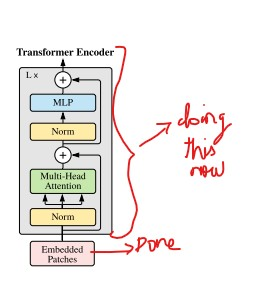

* MultiHeadAttention reference:https://www.tensorflow.org/api_docs/python/tf/keras/layers/MultiHeadAttention
*TransformerEncoder reference: https://www.tensorflow.org/api_docs/python/tfm/nlp/models/TransformerEncoder

In [43]:
# My TransformerEncoder custom class inherits from the layer class
class TransformerEncoder(Layer):
  def __init__(self,N_HEADS, HIDDEN_SIZE): #Constructor: defines the layers used in the model
    super(TransformerEncoder,self).__init__(name='transformer_encoder')

    # 2 layer Normalization blocks
    self.layer_norm_1=LayerNormalization()
    self.layer_norm_2=LayerNormalization()


    #one multihead block
    self.multi_head_att=MultiHeadAttention(N_HEADS,HIDDEN_SIZE )

    # MLP block has 2 fully connected dense layers
    self.dense_1=Dense(HIDDEN_SIZE,activation=tf.nn.gelu) #gelu as it used in the research paper
    self.dense_2=Dense(HIDDEN_SIZE,activation=tf.nn.gelu)

  def call(self,input): #set up call for all layers

    x_1 = self.layer_norm_1(input)
    x_1 = self.multi_head_att(x_1, x_1)

    # Add input back to the MHA output (residual connection)
    x_1= Add()([x_1,input])

    x_2 = self.layer_norm_2(x_1)

    #MLP has 2 dense layers
    x_2 = self.dense_1(x_2)
    output = self. dense_2(x_2)

    # Add input back to the MLP output (residual connection)
    output = Add()([output,x_1])

    return output

In [44]:
#call the encoder function and test an image
trans_enc = TransformerEncoder(N_HEADS=8, HIDDEN_SIZE=768)

#dry run test the encoder with zeros
trans_enc(tf.zeros([1,256,768]))  ## 1:batch,256=height,768=dimensions

<tf.Tensor: shape=(1, 256, 768), dtype=float32, numpy=
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]], dtype=float32)>

* Here I will make use of PatchEncoder and TransformerEncoder defined above"

In [45]:
# My Vision Transformer Model custom class inherits from the Model class
class ViT(Model):
  def __init__(self, N_HEADS, HIDDEN_SIZE, N_PATCHES, N_LAYERS, N_DENSE_UNITS):# Constructor: defines the layers used in the model
    super(ViT, self).__init__(name = 'vision_transformer')
    self.N_LAYERS = N_LAYERS

    # patch encoder
    self.patch_encoder = PatchEncoder(N_PATCHES, HIDDEN_SIZE)
    # since there will be L X layers of transformer_encoder, quick check on diagram helps
    self.trans_encoders = [TransformerEncoder(N_HEADS, HIDDEN_SIZE) for _ in range(N_LAYERS)]
    #MLP block has dense layer
    self.dense_1 = Dense(N_DENSE_UNITS, tf.nn.gelu)
    self.dense_2 = Dense(N_DENSE_UNITS, tf.nn.gelu)
    self.dense_3 = Dense(CONFIGURATION["NUM_CLASSES"], activation = 'softmax')


  def call(self, input, training = True):# Forward pass: defines how input data flows through the model

    x = self.patch_encoder(input)

    #looping through all transformer encoder layers
    for i in range(self.N_LAYERS):
      x = self.trans_encoders[i](x)
    x = Flatten()(x)
    x = self.dense_1(x)
    x = self.dense_2(x)

    return self.dense_3(x)

In [46]:
#call the encoder function and test an image
vit = ViT(N_HEADS = 4,HIDDEN_SIZE = 768,N_PATCHES= 256,N_LAYERS=2,N_DENSE_UNITS=1028)

#dry run test the encoder with zeros
vit(tf.zeros([1,256,256,3])) # 3 means channels

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[0.2687687 , 0.18410748, 0.54712385]], dtype=float32)>

In [47]:
vit.summary()

Model: "vision_transformer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ patch_encoder (PatchEncoder)         │ ?                           │         787,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_encoder                  │ ?                           │      10,631,424 │
│ (TransformerEncoder)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_encoder                  │ ?                           │      10,631,424 │
│ (TransformerEncoder)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (1, 1028)                   │     202,114,052 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (1, 1028)                   │       1,057,812 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (1, 3)                      │           3,087 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 225,224,999 (859.17 MB)

 Trainable params: 225,224,999 (859.17 MB)

 Non-trainable params: 0 (0.00 B)

## HuggingFace ViT

* TFViTForImageClassification reference : https://huggingface.co/docs/transformers/en/model_doc/vit#transformers.TFViTForImageClassification
* understamd epsilon : https://www.tensorflow.org/api_docs/python/tf/keras/layers/LayerNormalization - Small float added to variance to avoid dividing by zero. Defaults to 1e-3."

### Installation

In [48]:
!pip install transformers

* reference : https://huggingface.co/docs/transformers/en/model_doc/vit#transformers.ViTConfig

#### Working Code

In [ ]:
# # 1. Preprocessing function
# def preprocess(x):
#     x = tf.image.resize(x/255., [224,224])  ## Resize image to 224x224
#     x = (x - [0.485,0.456,0.406])/[0.229,0.224,0.225]  ## Normalize the image using ImageNet's mean and std values
#     return tf.transpose(x, perm=[0,3,1,2])  # Channels-first

In [ ]:
# # 2. ViT Wrapper that handles Keras tensors
# class ViTWrapper(tf.keras.layers.Layer):
#     def __init__(self, vit_model, **kwargs):
#         super().__init__(**kwargs)
#         self.vit = vit_model

#     def call(self, inputs):
#         # Convert Keras tensor to concrete tensor
#         outputs = self.vit(pixel_values=inputs)
#         return outputs.last_hidden_state[:,0,:]

In [ ]:
# # 3. Build Model
# from transformers import TFViTModel

# vit_model = TFViTModel.from_pretrained("google/vit-base-patch16-224-in21k")
# vit_model.trainable = False

# inputs = Input(shape=(256, 256, 3))
# x = Lambda(preprocess, output_shape=(3,224,224))(inputs)
# x = ViTWrapper(vit_model)(x)
# outputs = Dense(CONFIGURATION["NUM_CLASSES"], activation='softmax')(x)
# hf_model = Model(inputs, outputs)


In [ ]:
# # 4. Print Summary
# vit_params = sum(tf.size(w).numpy() for w in vit_model.weights)
# dense_params = sum(tf.size(w).numpy() for w in hf_model.layers[-1].weights)

In [ ]:
# print(f"\n{' MODEL SUMMARY ':=^60}")
# print(f"{'Total params:':<20} {vit_params + dense_params:,}")
# print(f"{'Trainable params:':<20} {dense_params:,}")
# print(f"{'Non-trainable params:':<20} {vit_params:,}")
# print("="*60)
# print(f"{'Layer':<15} {'Output Shape':<20} {'Params':>10}")
# print("-"*60)
# print(f"{'Input':<15} (None,256,256,3) {'0':>10}")
# print(f"{'Preprocess':<15} (None,3,224,224) {'0':>10}")
# print(f"{'ViT':<15} (None,768) {f'{vit_params:,}':>10}")
# print(f"{'Output':<15} (None,5) {f'{dense_params:,}':>10}")

In [ ]:
# test_image = cv2.imread("/content/dataset/Emotions Dataset/Emotions Dataset/train/happy/387249.jpg")
# # Resize to the input size expected by the model
# test_image = cv2.resize(test_image, (CONFIGURATION["IM_SIZE"] ,CONFIGURATION["IM_SIZE"]))

# #expand dims to display
# hf_model(tf.expand_dims(test_image, axis = 0))

### Training ViTHF